In [2]:
import Pkg
Pkg.add("Distributions")
Pkg.add("StatsPlots")
Pkg.add("SpecialFunctions")
Pkg.add("QuadGK")
using Random, Distributions, StatsPlots, SpecialFunctions, QuadGK

In [3]:
## Point Process

function counter(time::Number, events::Array{<:Number})
    n = 0
    if minimum(events) >= time
        return 0
    else
        for k = 1:length(events)
            if events[k] < time
                n += 1
            end
        end
        return n
    end
end

counter (generic function with 1 method)

In [4]:
## Hawkes Intensity

function compensator(time::Number, events::Array{<:Number}, mu::Number, kern::Function)
    if minimum(events) >= time
        return mu
    else
        return mu + sum(kern, time .- events[events .< time])
    end
end

compensator (generic function with 1 method)

In [5]:
## Ignore for now

function spInt(f::Function, discs::Array{<:Number}, x::Number)
    ans = 0
    if x < minimum(discs)
        ans = quadgk(u->f(u),0,x)[1]
    elseif x >= minimum(discs)
        former = discs[discs .< x]
        l = length(former)
        ans = ans + quadgk(u -> f(u),0,former[1])[1]
        if l >= 2
            for i in 2:l
                ans = ans + quadgk(u -> f(u),former[i-1],former[i])[1]
            end
        end
        ans = ans + quadgk(u -> f(u),former[l],x)[1]
    end
    return ans
end

spInt (generic function with 1 method)

In [6]:
## For integrating

function riemannSum(time::Number, f::Function, delta::Number)
    i = 1
    sum = 0
    while i*delta <= time
        sum = sum + delta*f(delta*(i-1))
        i += 1
    end
    if i*delta <= 1
        sum = sum + (time-delta*(i-1))*f(delta*(i-1))
    end
    return sum
end

riemannSum (generic function with 1 method)

In [7]:
function simulate()
    
## Initializing constants/scaling factors and preparing arrays for population
    
    n = 50
    alpha = 4
    dt = 1/500
    mun = 10*n ## NHT
    ##mun = n^alpha ## Heavy Tail
    an = 1-1/(1000*n) ## NHT
    lambda = n*(1-an) ## NHT
    sigma = 1000
    chi = 1/alpha
    mCon = sigma*alpha/(alpha-1) ## NHT
    
    numImmigrants = 0
    while numImmigrants == 0
        numImmigrants = rand(Poisson(mun))
    end
    events = Float64[]

## Forming the first generation of Immigrants

    for i in 1:numImmigrants              
        U = rand(Uniform())
        push!(events,U)
    end

## Creating a cycle for future generations to have children

    currentGen = events
    nextGen = Float64[]

    while length(currentGen) > 0                                    
        for j in 1:length(currentGen)                               
             numNextGen = rand(Poisson(an))                          
            if numNextGen != 0                                      
                for k in 1:numNextGen                               
                    pos = rand(GeneralizedPareto(0,sigma,chi))        
                    child = currentGen[j]+pos                       
                    if child < 1
                        push!(nextGen,child)
                        push!(events,child)
                    end
                end
            end
        end
        currentGen = nextGen
        nextGen = Float64[]
    end

## Creating the necessary functions to see the model in action

    events = sort(events)
    kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
    pointProcess(x) = counter(x,events)
    intensity(x) = compensator(x,events,mun,kernel)
    integratedIntensity(x) = riemannSum(x,intensity,dt)
    ##integratedIntensity(x) = spInt(intensity,events,x)
    martingale(x) = pointProcess(x) - integratedIntensity(x)
    
## Plots for functions
    
    p1 = plot(kernel,0,1)
    p2 = plot(pointProcess,0,1)
    p3 = plot(intensity,0,1)
    p4 = plot(martingale,0,1)

## Attempthing to make a BM

    M = convert(Int,floor(1/dt))
    martVec = zeros(M+1)
    lamVec = zeros(M+1)
    diffVec = zeros(M)
    N = 0
    while N <= M
        martVec[N+1] = martingale(N*dt)
        lamVec[N+1] = intensity(N*dt) 
        if N >= 1
            diffVec[N] = martVec[N+1] - martVec[N]
        end
        N += 1
    end
    newlamVec = view(lamVec,1:M)
    partSum = zeros(M)
    partSum = (1/sqrt(n)).*diffVec./sqrt.(newlamVec)
    cumSum = accumulate(+,partSum)
    BMVec = pushfirst!(cumSum,0)
    
## Checking rescaled intensities
    
    intC = (1-an).*lamVec
    integrand1 = (mun.-intC).*(lambda/mCon)
    integrand2 = (sqrt(lambda)/mCon).*sqrt.(intC)
    partSum1 = view(integrand1,1:M).*dt
    partSum2 = view(integrand2,1:M).*diffVec
    newCumSum = accumulate(+,partSum1+partSum2)
    RHS = pushfirst!(newCumSum,0)
    difference = RHS.-intC
    #return difference,maximum(abs.(difference))
    x = 0:dt:1
    y = (mCon/sqrt(lambda)).*(intC.-pushfirst!(accumulate(+,partSum1),0))
    return plot(x,y)
    #plot(p1,p2,p3,p4, layout = (2,2))
end

simulate (generic function with 1 method)

In [8]:
function genEvents(alpha::Number, mu::Number, an::Number, sigma::Number)

## Initializing constants/scaling factors and preparing arrays for population
    
    chi = 1/alpha
    
    numImmigrants = 0
    while numImmigrants == 0
        numImmigrants = rand(Poisson(mu))
    end
    events = Float64[]

## Forming the first generation of Immigrants

    for i in 1:numImmigrants              
        U = rand(Uniform())
        push!(events,U)
    end

## Creating a cycle for future generations to have children

    currentGen = events
    nextGen = Float64[]

    while length(currentGen) > 0                                    
        for j in 1:length(currentGen)                               
             numNextGen = rand(Poisson(an))                          
            if numNextGen != 0                                      
                for k in 1:numNextGen                               
                    pos = rand(GeneralizedPareto(0,sigma,chi))        
                    child = currentGen[j]+pos                       
                    if child < 1
                        push!(nextGen,child)
                        push!(events,child)
                    end
                end
            end
        end
        currentGen = nextGen
        nextGen = Float64[]
    end

    events = sort(events)
    return events
end

genEvents (generic function with 1 method)

In [9]:
function plotHawkes(alpha::Number, mu::Number, an::Number, sigma::Number, n::Number, dt::Number)
    
    chi = 1/alpha
    events = genEvents(alpha,mu,an,sigma)

## Functions for model    
    
    kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
    pointProcess(x) = counter(x,events)
    intensity(x) = compensator(x,events,mu,kernel)
    integratedIntensity(x) = riemannSum(x,intensity,dt)
    martingale(x) = pointProcess(x) - integratedIntensity(x)
    
    p1 = plot(kernel,0,1)
    p2 = plot(pointProcess,0,1)
    p3 = plot(intensity,0,1)
    p4 = plot(martingale,0,1)
    
    plot(p1,p2,p3,p4, layout = (2,2))
end

plotHawkes (generic function with 1 method)

In [10]:
function discretize(martingale::Function, intensity::Function, n::Number, dt::Number)
    
    M = convert(Int,floor(1/dt))
    martVec = zeros(M+1)
    lamVec = zeros(M+1)
    diffVec = zeros(M)
    N = 0
    
## Discretizing the functions    
    
    while N <= M
        martVec[N+1] = martingale(N*dt)
        lamVec[N+1] = intensity(N*dt) 
        if N >= 1
            diffVec[N] = martVec[N+1] - martVec[N]
        end
        N += 1
    end
## Making the Brownian Motion
    
    newlamVec = view(lamVec,1:M)
    partSum = zeros(M)
    partSum = (1/sqrt(n)).*diffVec./sqrt.(newlamVec)
    cumSum = accumulate(+,partSum)
    BMVec = pushfirst!(cumSum,0)
    
    return BMVec, lamVec, diffVec, martVec
end

discretize (generic function with 1 method)

In [11]:
function testRescaled(alpha::Number, mu::Number, an::Number, sigma::Number, n::Number, dt::Number, lamVec::Array{<:Number}, diffVec::Array{<:Number})
    
    M = convert(Int,floor(1/dt))
    lCon = n*(1-an)
    mCon = sigma*alpha/(alpha-1)
    intC = (1-an).*lamVec
    
    integrand1 = (mu .- intC) .* (lCon/mCon)
    integrand2 = (sqrt(lCon)/mCon) .* sqrt.(intC)
    
    partSum1 = view(integrand1,1:M) .* dt
    partSum2 = view(integrand2,1:M) .* diffVec
    newCumSum = accumulate(+,partSum1+partSum2)

## Right hand side p608    
    
    RHS = pushfirst!(newCumSum,0)
    
    difference = intC .- RHS
    #return difference,maximum(abs.(difference))
    x = 0:dt:1
    y = difference
    return plot(x,y),maximum(abs.(difference))
end

testRescaled (generic function with 1 method)

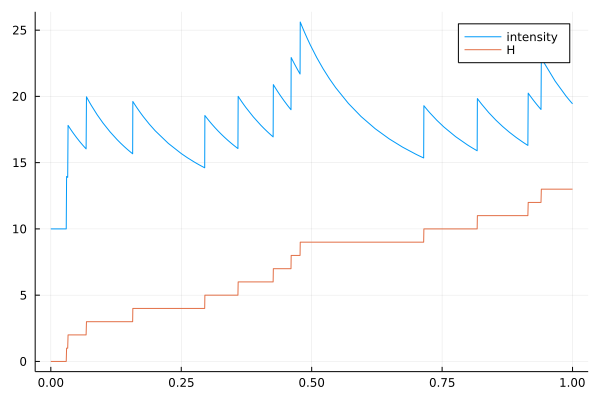

In [42]:
n=20
alpha = 1
dt=1/5
sigma = 5
chi = 1/alpha
mu = 10
an = .99
events = genEvents(alpha,mu,an,sigma)

kernel(x) = an*n*pdf(GeneralizedPareto(0,sigma,chi),n*x)
pointProcess(x) = counter(x,events)
intensity(x) = compensator(x,events,mu,kernel)
integratedIntensity(x) = riemannSum(x,intensity,dt)
martingale(x) = pointProcess(x) - integratedIntensity(x)

lamVec = discretize(martingale, intensity, n, dt)[2]
diffVec = discretize(martingale, intensity, n, dt)[3]
p = plot([intensity pointProcess],0,1, label = ["intensity" "H"])
#p = testRescaled(alpha,mu,an,sigma,n,dt,lamVec,diffVec)[1]
Plots.display(p)
#estRescaled(alpha,mu,an,sigma,n,dt,lamVec,diffVec)[2]

  5.232597 seconds (10.50 M allocations: 4.257 GiB, 6.70% gc time, 28.28% compilation time)


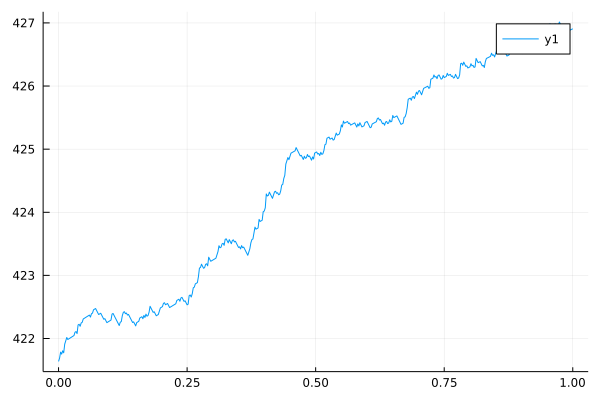

In [179]:
@time begin
simulate()
end

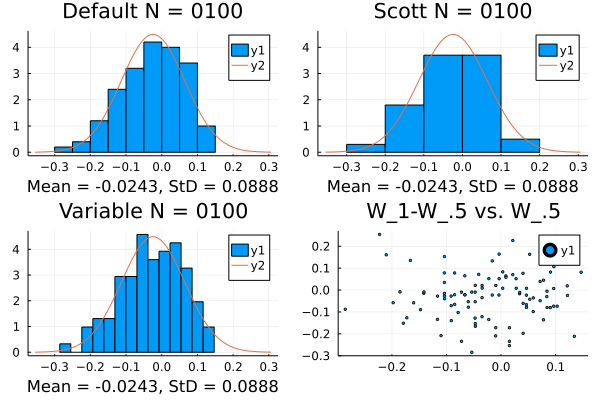

751.832853 seconds (1.63 G allocations: 933.260 GiB, 6.84% gc time)


In [14]:
## To form histograms and scatterplot

@time begin
N = 100
a = string(N,base = 10, pad = 4)
data = zeros(N)
inc = zeros(N)
for k in 1:N
    testVec = simulate()
    leng = length(testVec)
    half = convert(Int,(leng-1)/2+1)
    data[k] = testVec[half]
    inc[k] = testVec[leng]-testVec[half]
end
    
m = round(mean(data),digits=4)
s = round(std(data; corrected = false),digits=4)
mm = string(m)
ss = string(s)
    
q1 = plot(histogram(
    data,
    title = "Default N = "*a,
    xlabel = "Mean = "*mm*", StD = "*ss,
    normalize = true))
plot!(Normal(mean(data),std(data; corrected = false)))
q2 = Plots.plot(histogram(
    data,
    title = "Scott N = "*a,
    bins = :scott,
    xlabel = "Mean = "*mm*", StD = "*ss,
    normalize = true))
plot!(Normal(mean(data),std(data; corrected = false)))
q3 = Plots.plot(histogram(
    data,
    title = "Variable N = "*a,
    bins = range(minimum(data),stop = maximum(data), length = 15),
    xlabel = "Mean = "*mm*", StD = "*ss,
    normalize = true))
plot!(Normal(mean(data),std(data; corrected = false)))
q4 = scatter(
    data,
    inc,
    markersize=1.5,
    title = "W_1-W_.5 vs. W_.5")

q = Plots.plot(q1,q2,q3,q4, layout = (2,2))
Plots.display(q)
end

In [ ]:
## If changes are needed

q3 = Plots.plot(histogram(
    data,
    title = "Variable N = "*a,
    bins = range(minimum(data),stop = maximum(data), length = 10),
    xlabel = "Mean = "*mm*", StD = "*ss,
    normalize = true))
plot!(Normal(mean(data),std(data; corrected = false)))
q4 = scatter(data,inc,
    markersize=2,
    title = "W_1-W_.5 vs. W_.5")
q = Plots.plot(q1,q2,q3,q4, layout = (2,2))
Plots.display(q)